# Creating Structured Internal Fields from VTK
To create the structured internal field we can extract the centreline of the boundary and slice along it at equal intervals to obtain equally spaced contours. We can then parameterize the boundary of the domain and interpolate a set of structured datapoints using [transfinite interpolation](https://en.wikipedia.org/wiki/Transfinite_interpolation#:~:text=In%20numerical%20analysis%2C%20transfinite%20interpolation,field%20of%20finite%20element%20method.). By controlling the density of the interpolation we can control the overall accuracy of the warm-start prediction. 

After completing a CFD simulation in OpenFoam we can make processing the case simpler by converting the cases into VTK format using the command 'foamToVTK'. The resulting folder will have the following structure:

![](./images/foam_vtk_example.png)

We can now easily view and interact with the resulting CFD data in python using pyvista

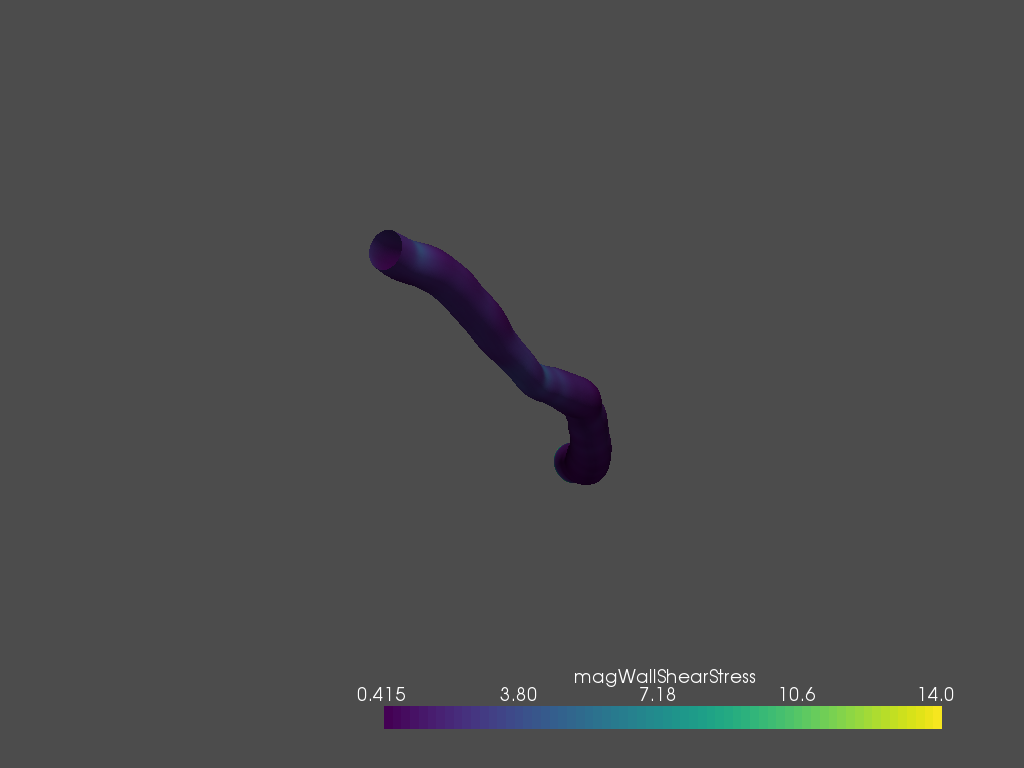

ERROR:root:The interactor must be set prior to enabling/disabling widget


In [1]:
import pathlib as pt
import pyvista as pv
wall_path = pt.Path("./test_data/00000/WALL/WALL_400.vtk")
wall_data = pv.read(wall_path)
wall_data.plot()

# Extracting the Centreline
We can extract the centreline using CGALMethods

In [2]:
# unwrap the artery
import pymethods as pma
import CGALMethods as cm
import pathlib as pt
case_folder = pt.Path("./test_data/00000") 
surface_mesh_path = case_folder/"WALL/WALL_400.vtk"
inlet_mesh_path = case_folder/"INLET/INLET_400.vtk"
# load the mesh as a CGAL surface mesh, we can use methods within the cgal library to extract the centreline of the mesh
cgal_mesh = cm.SurfaceMesh(surface_mesh_path.as_posix())
inlet_mesh = cm.SurfaceMesh(inlet_mesh_path.as_posix())


For some CGAL mesh we can view the property names with the property names method

In [3]:
inlet_mesh.property_names()

['v:U', 'v:U_0', 'v:magWallShearStress', 'v:p']

We can extract some field from the property mesh with the "get_property" method

In [4]:
inlet_velocity_field = inlet_mesh.get_property("v:U")
print(inlet_velocity_field.shape)

(2683, 3)


And we can extract the points of the mesh by calling the "points" method

In [5]:
inlet_points = inlet_mesh.points()
print(inlet_points.shape)

(2683, 3)


In [6]:
# approximate the centre of the inlet
inlet_centroid = inlet_points.mean(0)

In [7]:
# now we can extract the centreline of the mesh
centreline_raw = pma.algorithms.unwrapping.get_centerline_from_cylindrical_mesh(cgal_mesh,inlet_origin=inlet_centroid)

In [8]:
from pymethods import pyplot as plt
import numpy as np
# make the plot shown an interactive widget
%matplotlib widget
# convert the centreline to a Curve object
centreline = pma.arrays.Curve(centreline_raw)
centreline.plot3d(".", label="original")
# now divide the centreline into 300 equally spaced points
centreline = centreline(np.linspace(0,1, 300))
centreline.plot3d(".", label="interpolated")
plt.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Unwrapping the Mesh Using The Centreline
Once we have the centreline using CGALMethods we can process the mesh in pyvista

In [9]:
# we see that the mesh has been unwrapped to a grid, where the fields and points have been interpolated using b-spline curves
point_grid, field_grid = pma.algorithms.unwrapping.unwrap_cylinder_vtk_from_centerline(centreline, wall_data)

In [10]:

f, axes = plt.subplots(1,3)
[ax.imshow(grid) for ax, grid in zip(axes, point_grid)] 
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [11]:
field_grid.keys()

dict_keys(['magWallShearStress', 'p', 'U', 'U_0'])

In [12]:
plt.figure()
plt.imshow(field_grid["magWallShearStress"][0])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [13]:
# visualize the points
plt.figure_3d()
point_grid.scatter3d(s=0.1)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [14]:
contour = pma.arrays.Contour(point_grid[:,:,0])
plt.figure_3d()
contour.scatter3d()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Creating Structured Grid For a Single Contour
We can generate a structured grid over a single contour using transfinite interpolation

In [15]:
# to interpolate a single contour
transfinite_interpolator = pma.algorithms.transfinite_interpolation.Transfinite2d(contour)

interpolated_contour = transfinite_interpolator.pts_mesh_uniform(10, 10)
print("the shape of the interpolated grid:", interpolated_contour.shape)
# now plot the grid
plt.figure_3d()
contour.plot3d("r")
plt.plot_grid3d(interpolated_contour, "b")

# note the interpolator completely parameterizes the domain
# so can directly interpolate desired points
transfinite_interpolator(0.5, 0.5).scatter3d()
transfinite_interpolator(0.25, 0.25).scatter3d()
transfinite_interpolator(0.75, 0.75).scatter3d()

plt.equal_aspect_3d()
plt.show()

the shape of the interpolated grid: (3, 10, 10)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Creating a Structured Grid over the 3D Parameterized Domain

In [16]:
# create the structured mesh
structured_mesh_boundary = pma.arrays.structured.CylindricalSurface(point_grid)

transfinite_interpolator = pma.algorithms.transfinite_interpolation.TransfiniteCylinder(structured_mesh_boundary)

structured_mesh_internal = transfinite_interpolator.pts_mesh_uniform(16, 16, 384)

print("interpolated shape along the cylinder:", structured_mesh_internal.shape)
# plot every tenth contour
plt.figure_3d()
for i in range(0, 100, 10):
   plt.plot_grid3d(structured_mesh_internal[:,:,:,i], "g")
plt.show()


interpolated shape along the cylinder: (3, 16, 16, 384)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Interpolating the Fields Over the Structured Domain
We can now interpolate the fields onto our structured domain using [inverse distance weighted nearest neighbour interpolation](https://s3-us-west-2.amazonaws.com/etalweb.joewheaton.org/Courses/GIS/2015/Lectures/1_Interpoloation_Geostatistics.pdf)

In [17]:
from scipy.spatial import cKDTree

# get the internal field of the original mesh
original_mesh_path = pt.Path("./test_data/00000/FOAM_400.vtk")
assert original_mesh_path.exists()

original_mesh = pv.read(original_mesh_path)

# create a kd tree for the original mesh
orinal_mesh_kdtree = cKDTree(original_mesh.points)


In [18]:
# convert the structured field into a list
list_structured_mesh_internal = structured_mesh_internal.reshape(3, -1).T
# make sure that when reshaped we get the same output when we transform back
f,ax = plt.subplots(2,1)
ax[0].imshow(structured_mesh_internal[0,:,:,0])
ax[1].imshow(list_structured_mesh_internal.T.reshape(*structured_mesh_internal.shape)[0,:,:,0])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [20]:
# get the pressure and velocity fields of the original mesh
U_orig = original_mesh.point_arrays["U"]
p_orig = original_mesh.point_arrays["p"]

# lets perform a simple convergeance test to check how many neighbours we could need
# l = (U_orig-U_back_interpolated)**2).mean() + ((p_orig-p_back_interpolated)**2).mean()

# create a kd tree for the structured mesh
structured_mesh_kdtree = cKDTree(list_structured_mesh_internal)

# set the number of neighbours note this might take awhile
neighbours_test = [2, 3, 4, 5, 6, 7, 8, 9, 10]
l = []
for neighbours in neighbours_test:
    distances, indices = orinal_mesh_kdtree.query(list_structured_mesh_internal, neighbours)
    # now apply inverse distance weighting interpolation
    U_interpolated = ((U_orig[indices]/distances[:, :, None]).sum(1))/(1/distances).sum(1)[:,None]
    p_interpolated = ((p_orig[indices]/distances).sum(1))/(1/distances).sum(1)
    # reinterpolate the structured mesh onto the original mesh
    distances, indices = structured_mesh_kdtree.query(original_mesh.points, neighbours)
    U_back_interpolated = ((U_interpolated[indices]/distances[:, :, None]).sum(1))/(1/distances).sum(1)[:,None]
    p_back_interpolated = ((p_interpolated[indices]/distances).sum(1))/(1/distances).sum(1)
    l.append(
        ((U_orig-U_back_interpolated)**2).mean() + ((p_orig-p_back_interpolated)**2).mean()
    )

# select the most optimal number of neighbours
n_optimal = neighbours_test[np.argmin(l)]

print(f"the most optimal number of neighbours from the neighbours tested is: {n_optimal}")

plt.figure()
plt.plot(neighbours_test, l)
plt.xlabel("neighbours")
plt.ylabel("loss")
plt.show()

# observe that 4 neighbours is optimal

the most optimal number of neighbours from the neighbours tested is: 4


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …